In [457]:
# %load_ext autoreload
# %autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer, NewtonOptimizer

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


# CSCI 0451: Implementing Logistic Regression


### Abstract

This is an implementation of Logistic Regression. In it, I explore the mathematics behind the algorithm and implement it in Python. I then test the algorithm on a dataset. I explore concepts such as momentum and overfitting using the algorithm.

My logistic.py code can be found at https://github.com/jnerenberg/jnerenberg.github.io/blob/main/posts/logistic%20regression/logistic.py.


### Experimental Data

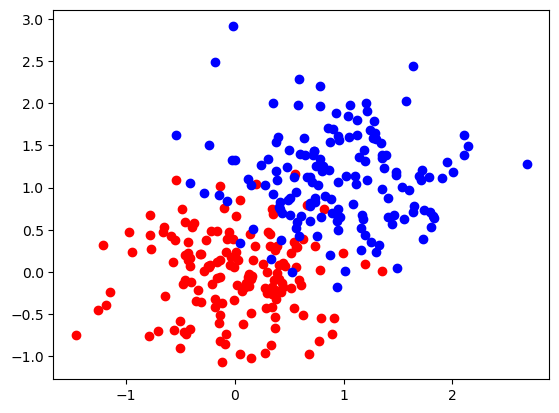

In [458]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.5)

# graph the data
plt.scatter(X[y == 0, 0], X[y == 0, 1], color = 'red')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color = 'blue')
plt.show()

### How to Train Your Dragon (Model)

In [459]:

import torch.nn as nn

# Get the number of features
input_dim = X.shape[1]

# Initialize the Logistic Regression model and the optimizer
LR = LogisticRegression(input_dim)  # Assuming binary classification
learning_rate = 0.01
opt = GradientDescentOptimizer(LR, learning_rate)

# Define the loss function
loss_function = nn.BCELoss()

for _ in range(100):
    # Compute the loss
    y_pred = LR(X)
    y = y.view(y_pred.shape)  # Reshape y to match y_pred
    loss = loss_function(y_pred, y)
    
    # Compute the gradients
    loss.backward()
    
    # Update the model parameters
    opt.step()
    
    # Zero the gradients
    LR.zero_grad()

##### Experiment 1: 

Vanilla gradient descent: When the number of features , when is sufficiently small and , gradient descent for logistic regression converges to a weight vector that looks visually correct (plot the decision boundary with the data). Furthermore, the loss decreases monotonically (plot the loss over iterations).

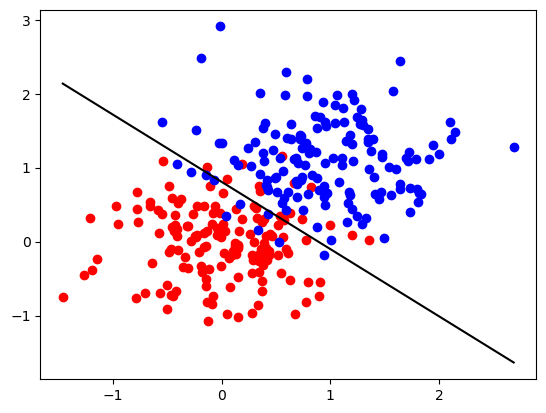

In [460]:
# Flatten y to a 1D tensor
y_flat = y.flatten()

# Plot the decision boundary
x1 = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
weights = LR.linear.weight.detach().numpy()  # Convert the weights to a numpy array
x2 = -(weights[0][0] * x1 + weights[0][2]) / weights[0][1]

plt.plot(x1, x2, color = 'black')
plt.scatter(X[y_flat == 0][:, 0], X[y_flat == 0][:, 1], color = 'red')
plt.scatter(X[y_flat == 1][:, 0], X[y_flat == 1][:, 1], color = 'blue')
plt.show()



Accuracy: 0.92


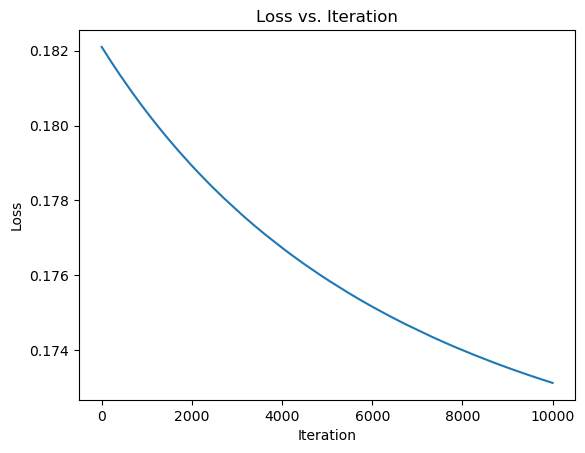

In [462]:
# print the accuracy
y_pred = LR(X)
y_pred = (y_pred > 0.5).float()
accuracy = accuracy_score(y, y_pred.detach().numpy())
print(f'Accuracy: {accuracy}')

# do the losses converge?
losses = []
for _ in range(10000):
    # Compute the loss
    y_pred = LR(X)
    y = y.view(y_pred.shape)  # Reshape y to match y_pred
    loss = loss_function(y_pred, y)
    losses.append(loss.item())
    
    # Compute the gradients
    loss.backward()
    
    # Update the model parameters
    opt.step()
    
    # Zero the gradients
    LR.zero_grad()

plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Iteration')
plt.show()



This looks like a decent linear decision boundary. It has an accuracy of 0.94, which I am happy with. It also looks similar to the line I would have chosen if I were to draw it by hand. The loss decreases with each iteration, which is also what I would expect, even though its a little slow.

##### Experiment 2: 

Benefits of momentum: On the same data, gradient descent with momentum (e.g. ) can converge to the correct weight vector in fewer iterations than vanilla gradient descent (with ). Plot the loss over iterations for each method. You may need to experiment with the data and choice of in order to observe speedups due to momentum.

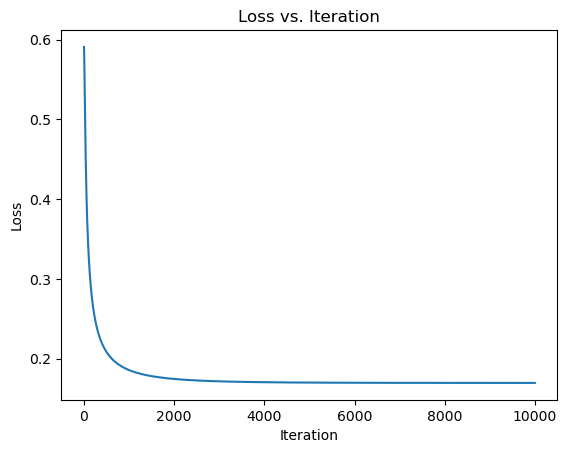

In [471]:
# Benefits of momentum: On the same data, gradient descent with momentum (e.g. ) can converge to the correct weight vector in fewer iterations than vanilla gradient descent (with ). Plot the loss over iterations for each method. You may need to experiment with the data and choice of in order to observe speedups due to momentum.

# momentum
w2 = torch.randn(input_dim, 1, requires_grad = True)
v = torch.zeros(input_dim, 1)
gamma = 0.9
learning_rate = 0.01
losses = []

for _ in range(10000):
    # Compute the loss
    y_pred = X @ w2
    y_pred = torch.sigmoid(y_pred)
    loss = loss_function(y_pred, y.view(y_pred.shape))
    losses.append(loss.item())
    
    # Compute the gradients
    loss.backward()
    
    # Update the model parameters
    with torch.no_grad():
        v = gamma * v + learning_rate * w2.grad
        w2 -= v
    
    # Zero the gradients
    w2.grad.zero_()

plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Iteration')
plt.show()


In [472]:
# print the accuracy
y_pred = LR(X)
y_pred = (y_pred > 0.5).float()
accuracy = accuracy_score(y, y_pred.detach().numpy())
print(f'Accuracy: {accuracy}')


Accuracy: 0.9166666666666666


Woah! This converges much faster than the vanilla gradient descent. The loss decreases much faster and the accuracy is pretty much the same. It took about a fifth of the iterations to converge to the same accuracy. This is a huge improvement.

##### Experiment 3: 

Overfitting: Generate some data where p_dim > n_points. For example, p_dim = 100 and n_points = 50. Do this twice with the exact same parameters. Call the first dataset X_train, y_train and the second dataset X_test, y_test. Then, do an experiment in which you fit a logistic regression model to the data X_train, y_train and obtain 100% accuracy on this training data. What is the accuracy on the test data?

In [483]:
# Overfitting: Generate some data where p_dim > n_points. For example, p_dim = 100 and n_points = 50. Do this twice with the exact same parameters. Call the first dataset X_train, y_train and the second dataset X_test, y_test. Then, do an experiment in which you fit a logistic regression model to the data X_train, y_train and obtain 100% accuracy on this training data. What is the accuracy on the test data?

X_train, y_train = classification_data(n_points = 50, noise = 0.8, p_dims = 100)
X_val, y_val = classification_data(n_points = 50, noise = 0.8, p_dims = 100)
X_test, y_test = classification_data(n_points = 50, noise = 0.8, p_dims = 100)

# Initialize the Logistic Regression model and the optimizer
input_dim = X_train.shape[1]
LR = LogisticRegression(input_dim)  # Assuming binary classification
learning_rate = 0.01
opt = GradientDescentOptimizer(LR, learning_rate)

# Define the loss function
loss_function = nn.BCELoss()

for _ in range(10000):
    # Compute the loss
    y_pred = LR(X_train)
    y_train = y_train.view(y_pred.shape)  # Reshape y to match y_pred
    loss = loss_function(y_pred, y_train)
    
    # Compute the gradients
    loss.backward()
    
    # Update the model parameters
    opt.step()
    
    # Zero the gradients
    LR.zero_grad()

# print the accuracy
y_pred = LR(X_train)
y_pred = (y_pred > 0.5).float()
accuracy = accuracy_score(y_train, y_pred.detach().numpy())
print(f'Training accuracy: {accuracy}')

# print the accuracy
y_pred = LR(X_val)
y_pred = (y_pred > 0.5).float()
accuracy = accuracy_score(y_val, y_pred.detach().numpy())
print(f'Validation accuracy: {accuracy}')

# print the accuracy
y_pred = LR(X_test)
y_pred = (y_pred > 0.5).float()
accuracy = accuracy_score(y_test, y_pred.detach().numpy())
print(f'Test accuracy: {accuracy}')

Training accuracy: 1.0
Validation accuracy: 0.98
Test accuracy: 0.88


Training accuracy is 1.0, which is expected since we have more features than data points. The test accuracy is 0.88, which is honestly better than I expected, but still overfitted.

### Conclusion

In conclusion, logistic regression is a powerful tool for binary classification. It is daunting yet rewarding to implement from scratch. I learned a lot about the math behind it and how to optimize it. I also learned about the importance of momentum in optimization. I am happy to better understand the tools we have been using and expect it will drastically improve my usage of the tool. Also, I am very confused by my desire to say "overfat" instead of "overfitted" when using the past tense of "overfit". Perhaps I am overfitting some other language rule to this word.